In [1]:
import os 
import pandas as pd

In [2]:
data_path = "dataset/enron1"

In [3]:
#Create list of dictionaries to hold data from dataset 
#Format: [{'filename': file, 'content': content, 'label': 'ham/spam'}]
ham = []
spam = []

In [4]:
#Fill the list using OS walk, return filled lists
def list_fill(ham, spam):
    for root, dirs, files in os.walk(data_path):
    #in subdirectory
        for file in files:
            with open(os.path.join(root, file), 'r', encoding='latin1') as f:
                content = f.read()
                #if in ham, append ham 
                if 'ham' in root:
                    ham.append({'filename': file, 'content': content, 'label': 'ham'})
                #if in spam, append spam
                elif 'spam' in root:
                    spam.append({'filename': file, 'content': content, 'label': 'spam'})
    return ham, spam

In [5]:
#Take in 2 lists, create 2 dataframes and then merge. Return merged dataframe
def create_df(ham, spam): 
    ham_df = pd.DataFrame(ham)
    spam_df = pd.DataFrame(spam)
    df = pd.concat([ham_df, spam_df], ignore_index = True)
    return df

In [6]:
#Create df, verifiy contents
ham, spam = list_fill(ham, spam)
df = create_df(ham, spam)
print(df.head)

<bound method NDFrame.head of                             filename  \
0     1365.2000-06-16.farmer.ham.txt   
1     3560.2001-02-09.farmer.ham.txt   
2     0877.2000-04-06.farmer.ham.txt   
3     2937.2000-11-27.farmer.ham.txt   
4     1270.2000-06-07.farmer.ham.txt   
...                              ...   
5167     1505.2004-07-09.GP.spam.txt   
5168     2148.2004-09-13.GP.spam.txt   
5169     2406.2004-10-06.GP.spam.txt   
5170     1459.2004-06-30.GP.spam.txt   
5171     2030.2004-08-30.GP.spam.txt   

                                                content label  
0     Subject: revised sea robin availabilities effe...   ham  
1     Subject: re : january spot purchases - deals n...   ham  
2     Subject: re : buyback / deficiency deals works...   ham  
3     Subject: king ranch processed volumes at tailg...   ham  
4     Subject: confirming requisitions\nconfirming t...   ham  
...                                                 ...   ...  
5167  Subject: what she doesnt know sprig

In [7]:
#Preprocessing phase. Filter text to be all lower case, remove punctuation and newline characters.
#Tokenize text and remove stopwords. Return filtered tokens.
import string 
import nltk
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
def preprocess(text): 
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.replace('\n', ' ')
    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    #stemmer = PorterStemmer()
    #stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    
    return ' '.join(filtered_tokens)

In [8]:
#Assign a new column for preprocessed content
df['preprocessed_content'] = df['content'].apply(preprocess)

subject 8 dear friend size 1 order confirmation order shipped january via fedex federal express tracking number 45954036 thank registering userid 56075519 learn make fortune ebay complete turnkey system software videos turorials clk information clilings


In [71]:
#Create generic train and predict functions. 
#Train takes in split training and testing values,and a model. returns fitted model. 
#Predict takes in X_test, X_train(for vectorization fitting), y_test values and model. Displays prediction for 
#first 5 iterations. 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer, X_train_vectorized, X_test_vectorized
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

def train(model):
        model.fit(X_train_vectorized, y_train)
        print(f'Model trained. Model testing score: {model.score(X_test_vectorized, y_test)}')
        return model
        
def predict(model, input_data): 
    if input_data == None: 
        for pred in range(5): 
            prediction = model.predict(X_test_vectorized)
            print(f'Predicted: {prediction[pred]}')
            print(f'Actual: {y_test.iloc[pred]}')
    else:
        input_data_vectorized = vectorizer.transform(input_data)
        prediction = model.predict(input_data_vectorized)
        print(f'Predicted: {prediction}')   

In [10]:
#Create model (In this case, decision tree)
#Establish X and y values. Split using train_test_split. 
#Assign model to trained model using train method.
#Show predictions for first 5 iterations, comparing predictions to actual values.
#Intuition = Decision tree will be a good choice. 
X = df['preprocessed_content']
y= df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .2, random_state= 42)

In [68]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
nb = MultinomialNB()

#Perform CV testing on prospective models
param_grid_knn = {'n_neighbors': [3, 5, 7, 9]}
param_grid_dt = {'max_depth': [None, 5, 10, 15]}
param_grid_rf = {'n_estimators': [50, 100, 150], 'max_depth': [None, 5, 10]}
param_grid_nb = {'alpha': [1.0, 0.1, 0.01, 0.001]}

grid_knn = GridSearchCV(knn, param_grid_knn, cv=5)
grid_dt = GridSearchCV(dt, param_grid_dt, cv=5)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5)
grid_nb = GridSearchCV(nb, param_grid_nb, cv = 5)

cv_models = [grid_knn, grid_dt, grid_rf, grid_nb]

for model in cv_models: 
    model = train(model)    

for model in cv_models:
    model_name = str(model.estimator).split('(')[0] 
    best_params = model.best_params_
    best_score = model.best_score_
    y_pred = model.best_estimator_.predict(X_test_vectorized)
    # Cleaning up and printing the output
    print(f"Best Params for {model_name}: {best_params}, Best training score: {best_score:.4f}")
    f1 = f1_score(y_test, y_pred, pos_label='spam')
    a_s = accuracy_score(y_test, y_pred)
    print(f'{model_name} F1 score: {f1}, Accuracy score: {a_s}')

Model trained. Model testing score: 0.9710144927536232
Model trained. Model testing score: 0.9439613526570049
Model trained. Model testing score: 0.9739130434782609
Model trained. Model testing score: 0.9845410628019323
Best Params for KNeighborsClassifier: {'n_neighbors': 9}, Best training score: 0.9589
KNeighborsClassifier F1 score: 0.9460431654676259, Accuracy score: 0.9710144927536232
Best Params for DecisionTreeClassifier: {'max_depth': None}, Best training score: 0.9437
DecisionTreeClassifier F1 score: 0.902027027027027, Accuracy score: 0.9439613526570049
Best Params for RandomForestClassifier: {'max_depth': None, 'n_estimators': 100}, Best training score: 0.9782
RandomForestClassifier F1 score: 0.9541595925297114, Accuracy score: 0.9739130434782609
Best Params for MultinomialNB: {'alpha': 0.1}, Best training score: 0.9787
MultinomialNB F1 score: 0.9723183391003459, Accuracy score: 0.9845410628019323


In [69]:
model = grid_nb.best_estimator_

In [72]:
#Give the model some new data: spam
spam_email = '''Subject: Exclusive Offer: Limited Time Deal

Dear Valued Customer,

Congratulations! You've been selected for an exclusive, limited-time offer. This incredible deal guarantees massive discounts on a wide range of products, including luxury items, gadgets, and more!

Act now to claim your prize. Click the link below to unlock these unbeatable savings!

Hurry! This offer is available for a limited time only. Don't miss out on this opportunity to save big!

Sincerely,
The Marketing Team
'''
spam_email_pre = preprocess(spam_email)
print(f'Sample spam email: {spam_email_pre}')
predict(model, [spam_email])


Sample spam email: subject exclusive offer limited time deal dear valued customer congratulations youve selected exclusive limitedtime offer incredible deal guarantees massive discounts wide range products including luxury items gadgets act claim prize click link unlock unbeatable savings hurry offer available limited time dont miss opportunity save big sincerely marketing team
Predicted: ['spam']


In [73]:
#Give the model some new data: ham
ham_email = '''Subject: Regarding the Upcoming Meeting

Dear Team,

I hope this message finds you well. I am writing to inform you about the upcoming meeting scheduled for next Wednesday at our office premises. We will be discussing the project updates, client presentations, and planning for the next quarter.

The meeting agenda and related documents have been shared via the internal drive. Please make sure to review them before the meeting for a productive discussion.

Your presence and active participation are highly appreciated.

Best regards,
[Your Name]'''
ham_email_pre = preprocess(ham_email)
print(f'Sample ham email: {ham_email_pre}')
predict(model, [ham_email_pre])

Sample ham email: subject regarding upcoming meeting dear team hope message finds well writing inform upcoming meeting scheduled next wednesday office premises discussing project updates client presentations planning next quarter meeting agenda related documents shared via internal drive please make sure review meeting productive discussion presence active participation highly appreciated best regards name
Predicted: ['ham']


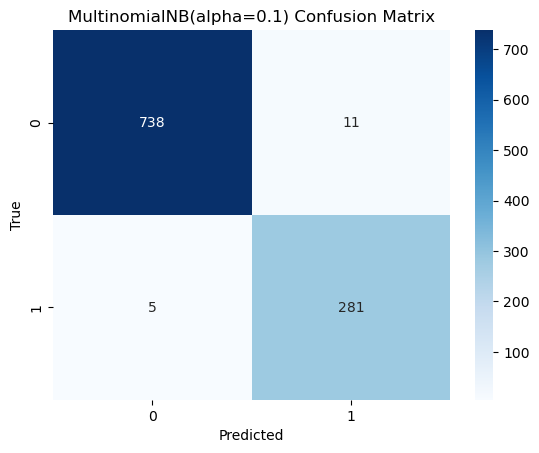

In [81]:
#Confusion matrix: 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
def display_cm(model): 
    y_pred = model.predict(X_test_vectorized)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{model} Confusion Matrix")
    plt.show()
display_cm(model)

Model trained. Model testing score: 0.8038647342995169


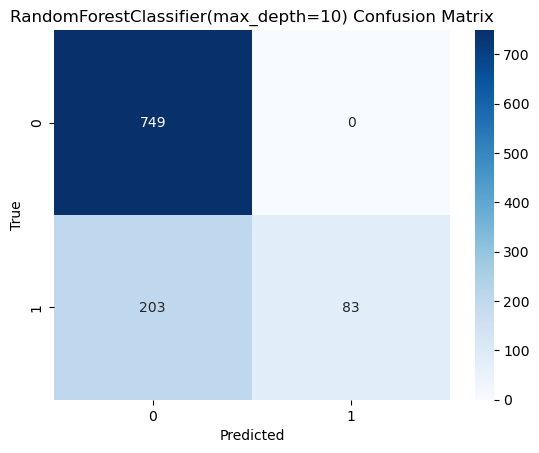

In [82]:
model_rf = RandomForestClassifier(max_depth = 10)
train(model_rf)
display_cm(model_rf)

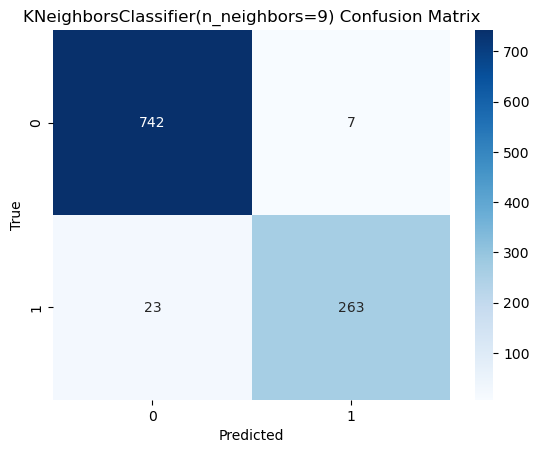

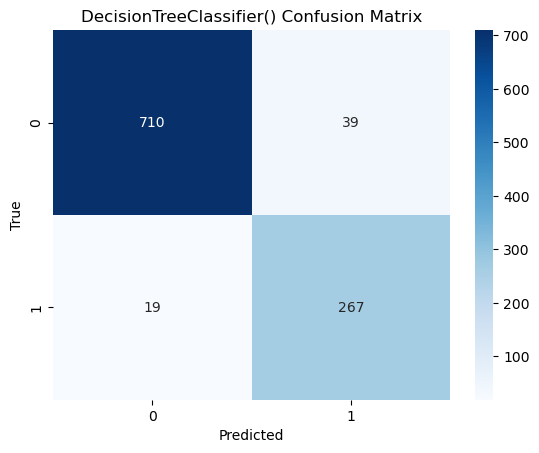

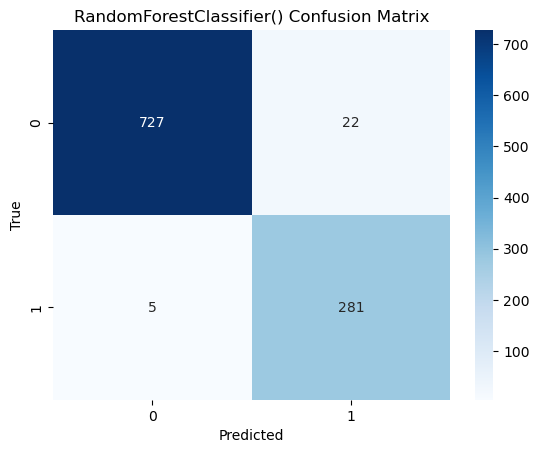

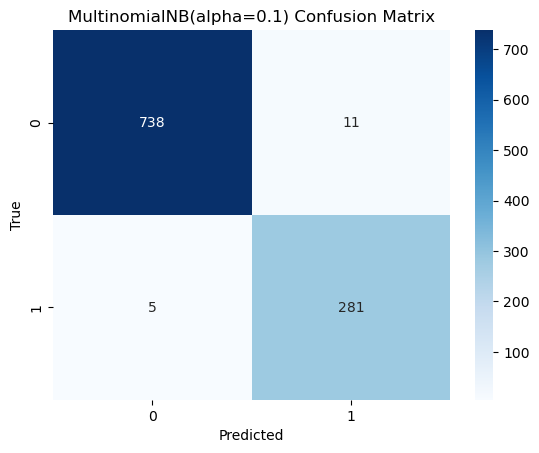

In [85]:
for model in cv_models: 
    display_cm(model.best_estimator_)